# Import Necessary Libraries 

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [68]:
df = pd.read_csv('marketing_campaign.csv',sep='\t')
df=df.drop(columns=["Z_CostContact", "Z_Revenue", "ID"],axis=1)
df.shape

(2240, 26)

In [69]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"],format= 'DD/MM/YYYY',infer_datetime_format=True)

In [70]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [71]:
#Age
df['Cust_age'] = 2014- df['Year_Birth']
#Total Spent
df['TotalSpent'] = df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']
#Number of purchase
df['NumAllPurchases'] = df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases']
# Number of children
df["No_Of_Children"] = df.Kidhome + df.Teenhome
df["Has_Child"] = np.where(df.No_Of_Children > 0, "Has Child", "No Child")

# dividing age into groups
df['Age_Group'] = pd.cut(x = df['Cust_age'], bins = [1, 17, 24, 44, 64, 90],
                         labels = ['Under 18','Young adult','Adult','Middel Aged','Senior Citizen'])

# number of days the customers started to shop in the store
days = []
d1 = max(df.Dt_Customer) #taking it to be the newest customer
for i in df.Dt_Customer:
    delta = d1 - i
    delta = delta.days
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

# Family size
df["Living_With"]=df["Marital_Status"].replace(
    {"Married":"Relationship", "Together":"Relationship", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", 
     "Divorced":"Alone", "Single":"Alone",})

df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Relationship":2})+ df["No_Of_Children"]

df = df.drop(['Dt_Customer','Year_Birth'],axis=1)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,22,0,No Child,Middel Aged,971,Alone,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,4,2,Has Child,Middel Aged,125,Alone,3
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,20,0,No Child,Middel Aged,472,Relationship,2
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,6,1,Has Child,Adult,65,Relationship,3
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,14,1,Has Child,Adult,321,Relationship,3


In [72]:
df = df[df.Income<195348.5]
df = df[df.Cust_age<84]
df.shape

(2212, 33)

In [73]:
df.isnull().sum()

Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Cust_age               0
TotalSpent             0
NumAllPurchases        0
No_Of_Children         0
Has_Child              0
Age_Group              0
Customer_For           0
Living_With            0
Family_Size            0
dtype: int64

In [74]:
df.shape

(2212, 33)

In [75]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,22,0,No Child,Middel Aged,971,Alone,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,4,2,Has Child,Middel Aged,125,Alone,3
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,20,0,No Child,Middel Aged,472,Relationship,2
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,6,1,Has Child,Adult,65,Relationship,3
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,14,1,Has Child,Adult,321,Relationship,3


In [77]:
df2 = df.copy()

#  Advanced analysis

## label encoding 

In [38]:
encoder = LabelEncoder()
df.Has_Child = encoder.fit_transform(df.Has_Child)
df.Living_With = encoder.fit_transform(df.Living_With)
df.Marital_Status = encoder.fit_transform(df.Marital_Status)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size
0,Graduation,4,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,22,0,1,Middel Aged,971,0,1
1,Graduation,4,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,4,2,0,Middel Aged,125,0,3
2,Graduation,5,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,20,0,1,Middel Aged,472,1,2
3,Graduation,5,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,6,1,0,Adult,65,1,3
4,PhD,3,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,14,1,0,Adult,321,1,3


In [39]:
encoder_Age_Group= ce.OrdinalEncoder(cols=['Age_Group'],return_df=True,
                           mapping=[{'col':'Age_Group',
'mapping':{'Under 18':0,'Young adult':1,'Adult':2,'Middel Aged':3,'Senior Citizen':4}}])

encoder_Education= ce.OrdinalEncoder(cols=['Education'],return_df=True,
                           mapping=[{'col':'Education',
'mapping':{'Basic':0,'Graduation':1,'Master':2,'2n Cycle':3,'PhD':4}}])

df = encoder_Education.fit_transform(df)
df = encoder_Age_Group.fit_transform(df)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size
0,1,4,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,22,0,1,3,971,0,1
1,1,4,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,4,2,0,3,125,0,3
2,1,5,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,20,0,1,3,472,1,2
3,1,5,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,6,1,0,2,65,1,3
4,4,3,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,14,1,0,2,321,1,3


df_relationship_staus = pd.get_dummies(df.Marital_Status)
df = pd.concat([df,df_relationship_staus], axis=1)
df = df.drop('Marital_Status',axis=1)

In [40]:
df = df.drop(['AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp2','AcceptedCmp1','Kidhome','Teenhome'], axis=1)
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size
0,1,4,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,57,1617,22,0,1,3,971,0,1
1,1,4,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,60,27,4,2,0,3,125,0,3
2,1,5,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,49,776,20,0,1,3,472,1,2
3,1,5,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,30,53,6,1,0,2,65,1,3
4,4,3,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,33,422,14,1,0,2,321,1,3


## Scaling

In [41]:
ds = df.copy()

#cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response','Kidhome','Teenhome']
#ds = ds.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
scaled_ds.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size
0,-0.777523,0.254760,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,-0.09552,2.375425,1.018352,1.676245,1.309461,-1.264598,1.581139,0.789588,1.973583,-1.349603,-1.758359
1,-0.777523,0.254760,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-0.09552,-0.420977,1.274785,-0.963297,-1.189221,1.404572,-0.632456,0.789588,-1.665144,-1.349603,0.449070
2,-0.777523,1.183144,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.09552,-0.420977,0.334530,0.280110,1.031830,-1.264598,1.581139,0.789588,-0.172664,0.740959,-0.654644
3,-0.777523,1.183144,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-0.09552,-0.420977,-1.289547,-0.920135,-0.911590,0.069987,-0.632456,-0.789588,-1.923210,0.740959,0.449070
4,1.625664,-0.673624,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.09552,-0.420977,-1.033114,-0.307562,0.198936,0.069987,-0.632456,-0.789588,-0.822130,0.740959,0.449070


In [42]:
scaled_ds.isnull().sum()

Education              0
Marital_Status         0
Income                 0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Complain               0
Response               0
Cust_age               0
TotalSpent             0
NumAllPurchases        0
No_Of_Children         0
Has_Child              0
Age_Group              0
Customer_For           0
Living_With            0
Family_Size            0
dtype: int64

## Dimensionality reduction

### Scree Plot

Text(0.5, 1.0, 'Scree Plot')

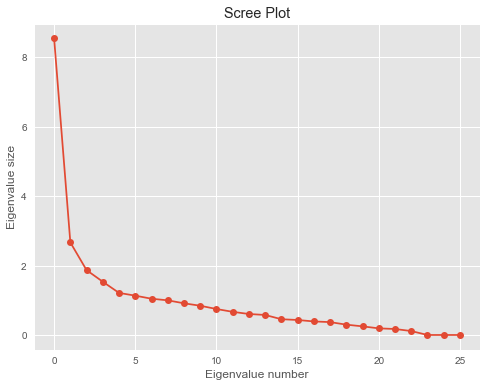

In [43]:
fig = plt.figure(figsize=(8,6))

pca = PCA(n_components=None)
pca.fit(scaled_ds)

plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [44]:
len(pca.explained_variance_ratio_)

26

In [45]:
#sum(pca.explained_variance_ratio_[:12])
var_exp = []
X=0
for i in range(len(pca.explained_variance_ratio_)):
    X +=  pca.explained_variance_ratio_[i]
    var_exp.append(X)
    
var_exp[11]

0.8520306352326352

Text(0.5, 1.0, 'Scree Plot')

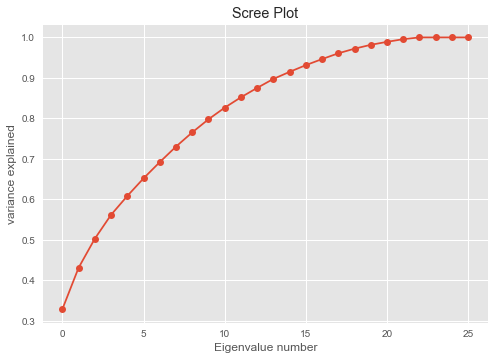

In [46]:
plt.style.use("ggplot") 
plt.plot(var_exp,marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("variance explained")
plt.title("Scree Plot")

In [47]:
pca = PCA(n_components=13)
pca.fit(scaled_ds)
PCA_ds =  pca.transform(scaled_ds) 

In [48]:
PCA_ds.shape

(2212, 13)

In [49]:
pca.explained_variance_*100/sum(pca.explained_variance_)

array([37.51494205, 11.70823444,  8.20219711,  6.73545334,  5.32115275,
        4.97427444,  4.5859624 ,  4.38365249,  4.00682067,  3.69936236,
        3.28622836,  2.92744182,  2.65427778])

In [50]:
mycolumns = ['Column_1','Column_2','Column_3','Column_4','Column_5','Column_6'
          ,'Column_7','Column_8','Column_8','Column_10','Column_11','Column_12','Column_13']

In [51]:
df_pca= pd.DataFrame(PCA_ds, columns = mycolumns)
df_pca.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_8,Column_10,Column_11,Column_12,Column_13
0,5.236059,-0.195637,0.971219,2.818084,-1.971663,1.422370,0.054152,-0.436173,-0.499294,1.722555,0.223362,-0.067924,-0.268847
1,-2.895112,-0.116956,-2.158873,0.191172,-0.364654,-0.766042,1.447583,-0.219277,1.106335,0.919109,-0.566369,0.255872,-0.076024
2,2.539399,-0.228881,-0.919337,-0.371616,-0.545137,1.062974,0.069297,-0.501688,0.666027,-2.171868,0.006600,0.132661,-0.630655
3,-2.905787,-1.273312,0.172381,-1.478004,0.626252,0.542831,0.571752,-0.424392,1.403890,-0.718418,-0.647300,-0.170207,-0.286433
4,-0.425265,0.640521,0.799926,-1.325877,1.109027,-1.459837,-1.159477,0.378131,-0.298719,0.526539,0.793217,-0.564736,0.262126


In [52]:
df_pca.to_csv('pca.csv', index= False)

### 2D-Plot

<AxesSubplot:xlabel='col1', ylabel='col2'>

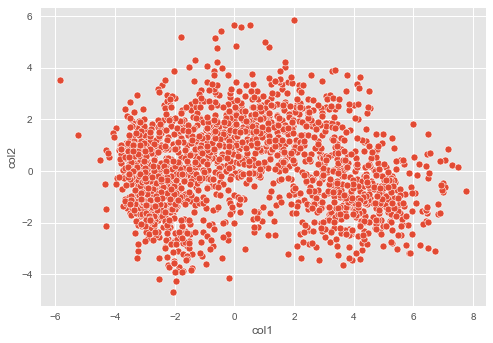

In [53]:
pca = PCA(n_components=2)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2"]))
sns.scatterplot(x=PCA_ds.col1, y=PCA_ds.col2)

### 3D-Plot

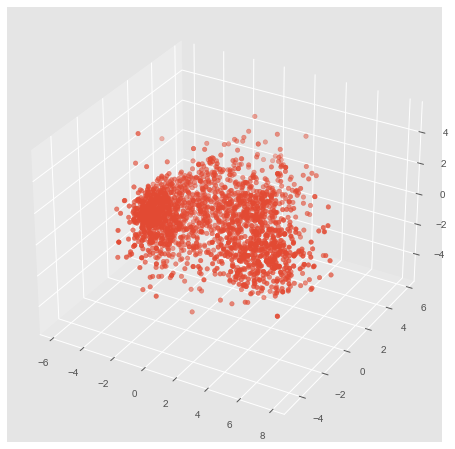

In [54]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2","col3"]))

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.scatter3D(xs=PCA_ds.col1, ys=PCA_ds.col2, zs=PCA_ds.col3, cmap='Greens');

# K-means

## Choosing ideal no of clusters

### 3.1.1  Elbow method

Elbow Method to determine the number of clusters to be formed:


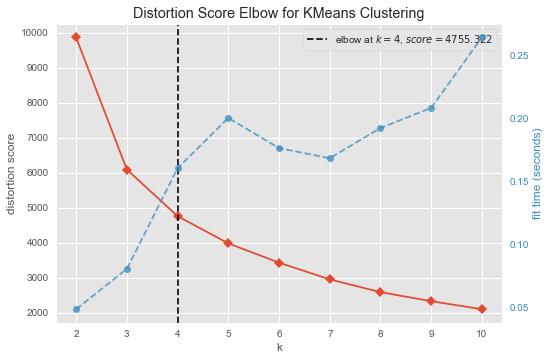

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
pca = PCA(n_components=2)
pca.fit(scaled_ds)
PCA_ds = pca.transform(scaled_ds)
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

### silhouette score and inertia

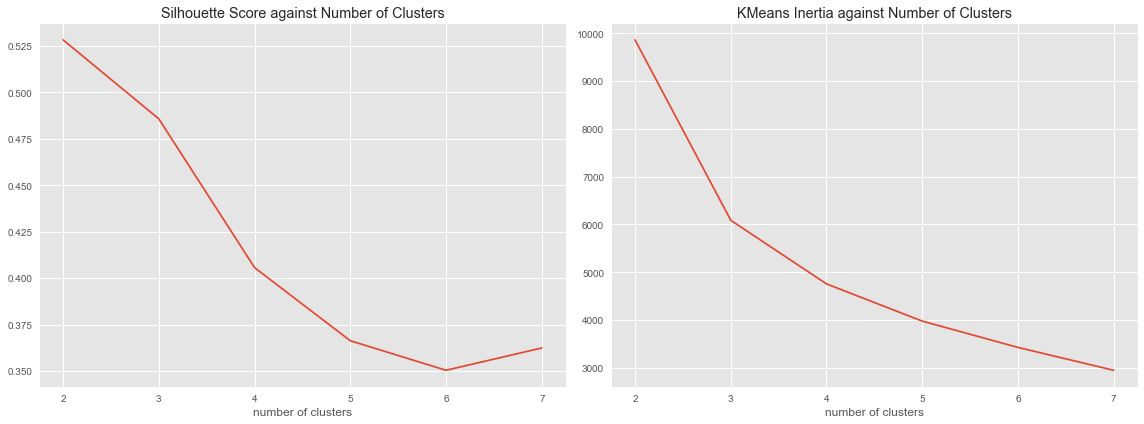

In [56]:
silhouette_score_list = []
inertia_list = []

for n in range(2, 8):
    kmeans = KMeans(n_clusters = n, random_state=0)
    kmeans.fit(PCA_ds)
    silhouette_score_list.append(silhouette_score(PCA_ds, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)
    
#plot
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(range(2, 8), silhouette_score_list, '-');
ax1.set_title('Silhouette Score against Number of Clusters')
ax1.set_xlabel('number of clusters')
ax2.plot(range(2, 8), inertia_list, '-')
ax2.set_title('KMeans Inertia against Number of Clusters')
ax2.set_xlabel('number of clusters')
plt.tight_layout();

### WCSS (within-cluster sum of square)

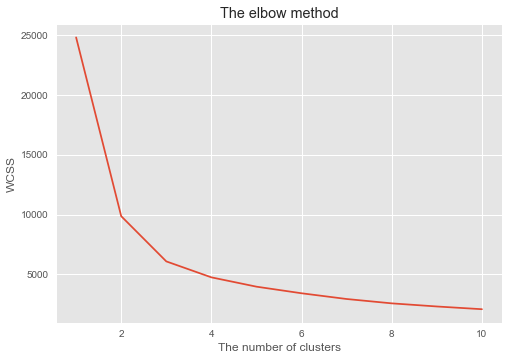

In [57]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(PCA_ds)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

## Visualizing Data

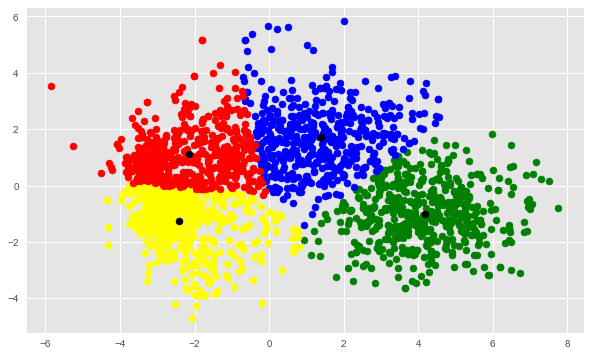

In [58]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)

pca = PCA(n_components=2)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2"]))

Y = kmeans.fit_predict(PCA_ds)

PCA_ds= PCA_ds.to_numpy()

plt.figure(figsize=(10,6))
plt.scatter(PCA_ds[Y==0,0], PCA_ds[Y==0,1], c='green')
plt.scatter(PCA_ds[Y==1,0], PCA_ds[Y==1,1], c='yellow')
plt.scatter(PCA_ds[Y==2,0], PCA_ds[Y==2,1], c='blue')
plt.scatter(PCA_ds[Y==3,0], PCA_ds[Y==3,1], c='red')
#plt.scatter(PCA_ds[Y==4,0], PCA_ds[Y==4,1], c='violet')


plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black')

plt.show()

 # Hierachical Clustering

# EDA

In [78]:
df2['cluster'] = Y

In [80]:
df2.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,22,0,No Child,Middel Aged,971,Alone,1,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,4,2,Has Child,Middel Aged,125,Alone,3,1
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,20,0,No Child,Middel Aged,472,Relationship,2,0
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,6,1,Has Child,Adult,65,Relationship,3,1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,14,1,Has Child,Adult,321,Relationship,3,3


In [81]:
df_marital = pd.read_csv('marketing_campaign.csv',sep='\t')
Marital_Status = df_marital.Marital_Status
df = pd.concat([df,Marital_Status], axis=1)
#df = df.drop('Marital_Status')
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size,Marital_Status
0,Graduation,Single,58138.0,0.0,0.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57.0,1617.0,22.0,0.0,No Child,Middel Aged,971.0,Alone,1.0,Single
1,Graduation,Single,46344.0,1.0,1.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,27.0,4.0,2.0,Has Child,Middel Aged,125.0,Alone,3.0,Single
2,Graduation,Together,71613.0,0.0,0.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,776.0,20.0,0.0,No Child,Middel Aged,472.0,Relationship,2.0,Together
3,Graduation,Together,26646.0,1.0,0.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,53.0,6.0,1.0,Has Child,Adult,65.0,Relationship,3.0,Together
4,PhD,Married,58293.0,1.0,0.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,3.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,422.0,14.0,1.0,Has Child,Adult,321.0,Relationship,3.0,Married


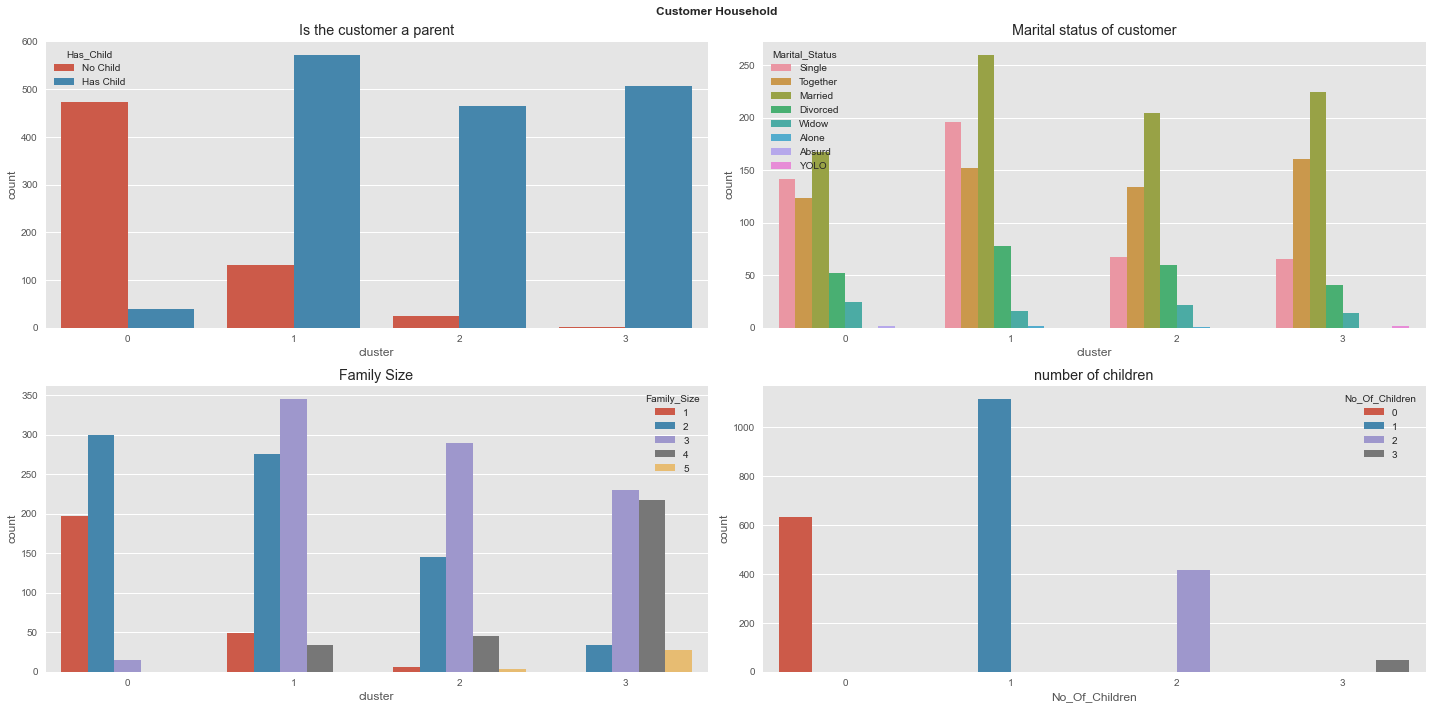

In [83]:
#subplots
fig, (ax) = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
fig.suptitle('Customer Household', fontweight='bold')

sns.countplot(hue='Has_Child', x='cluster', data=df2, ax=ax[0])
ax[0].set_title('Is the customer a parent')

#marital status of customer
sns.countplot(x='cluster', hue='Marital_Status', data=df2, ax=ax[1])
ax[1].set_title('Marital status of customer')

#number of members in household
sns.countplot(x='cluster', hue='Family_Size', data=df2, ax=ax[2])
ax[2].set_title('Family Size')

#number of children in household
sns.countplot(x='No_Of_Children', hue='No_Of_Children', data=df2, ax=ax[3])
ax[3].set_title('number of children')
plt.tight_layout();

In [84]:
df2.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_age,TotalSpent,NumAllPurchases,No_Of_Children,Has_Child,Age_Group,Customer_For,Living_With,Family_Size,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,22,0,No Child,Middel Aged,971,Alone,1,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,4,2,Has Child,Middel Aged,125,Alone,3,1
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,20,0,No Child,Middel Aged,472,Relationship,2,0
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,6,1,Has Child,Adult,65,Relationship,3,1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,14,1,Has Child,Adult,321,Relationship,3,3


In [85]:
cat_features = ['Education','Marital_Status','Has_Child','Age_Group']

Text(0, 0.5, 'mean number of purchases ')

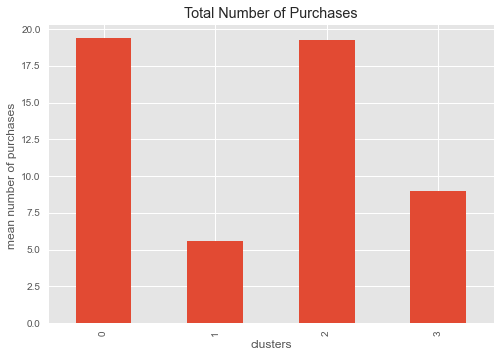

In [86]:
df2.groupby('cluster')['NumAllPurchases'].mean().plot.bar()
plt.title('Total Number of Purchases')
plt.xlabel('clusters')
plt.ylabel('mean number of purchases ')

Text(0, 0.5, 'mean number of Deal Purchases ')

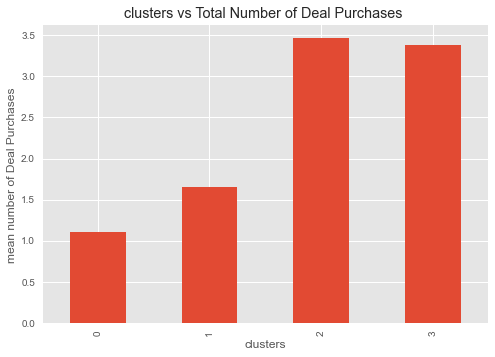

In [87]:
df2.groupby('cluster')['NumDealsPurchases'].mean().plot.bar()
plt.title('clusters vs Total Number of Deal Purchases ')
plt.xlabel('clusters')
plt.ylabel('mean number of Deal Purchases ')

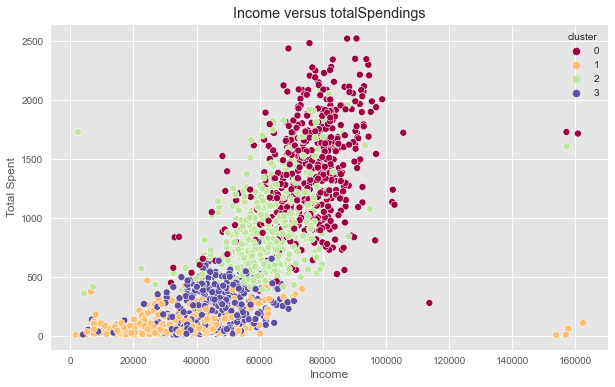

In [90]:
plt.figure(figsize=(10,6))
sns.scatterplot(y='TotalSpent', x='Income', hue='cluster', data=df2, palette='Spectral')
#plt.xlim([0, 200000])
plt.title('Income versus totalSpendings')
plt.ylabel('Total Spent');